In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import yfinance as yf
from tool_func import *
# suppose a fixed spread: 2pip
spread_float = 0.0002
def exit_p(fx_df,period_int):
    # exit at the breakout bar
    col_str = 'Close_'+str(period_int)+'D'
    fx_df.loc[:,col_str] = fx_df.loc[:,'Close'].shift(-period_int)
    low_exit_ser = fx_df.where((fx_df.loc[:,'sig']>0)&
                                 (fx_df.loc[:,col_str]<fx_df.loc[:,'last_low_stop'])).loc[:,'last_low_stop'].fillna(0)
    high_exit_ser = fx_df.where((fx_df.loc[:,'sig']<0) &
                                  (fx_df.loc[:,col_str]>fx_df.loc[:,'last_high_stop'])).loc[:,'last_high_stop'].fillna(0)
    exit_p_ser = low_exit_ser+high_exit_ser
    no_stop_list = np.where(exit_p_ser==0)[0].tolist()
    exit_p_ser.iloc[no_stop_list] = fx_df[col_str].iloc[no_stop_list].tolist()
    short_loc_list = np.where(fx_sp_df['sig']<0)[0].tolist()
    exit_p_ser.iloc[short_loc_list] =  exit_p_ser.iloc[short_loc_list]*(1+spread_float)
    fx_df.loc[:,'exit_price_'+str(period_int)+'D'] = exit_p_ser.tolist()
def simu_plot(simu_df,period_int):
    simu_ror_df = simu_df.loc[:,['ror_'+str(period_int)+'d']].dropna(axis=0)
    plt.figure(figsize=(10,5))
    simu_none0_array = simu_ror_df.where(simu_ror_df!=0.0).values
    plt.hist(simu_none0_array,bins=40,range = (-0.03,0.03))
    plt.title("Simu"+str(period_int)+'D ror distribution')
    plt.show()
    simu_ror_array = simu_df.loc[:,['ror_'+str(period_int)+'d']].fillna(0).values
    accu_ret_array = np.exp(np.add.accumulate(np.log(simu_ror_array+1)))-1
    plt.figure(figsize=(10,5))
    annual_ror_float = annualized_ror(simu_ror_array)[0]
    annual_ror_float = np.round(annual_ror_float,2)
    plt.plot(accu_ret_array,label = 'Annual Ror: '+str(annual_ror_float))
    plt.title("Simu"+str(period_int)+'D daily accumulate ror')
    plt.legend()
    plt.show()


In [2]:
fx_df = pd.read_csv(r'E:\study\22fall\hf\data\NR4\FX_G10.csv')
fx_df.loc[:,'Date'] = pd.to_datetime(fx_df.loc[:,'Date'])+dt.timedelta(days=-1)
fx_df.loc[:,'range'] = fx_df.loc[:,'High']-fx_df.loc[:,'Low']
range_df = fx_df.loc[:,['Date','ticker','range']].pivot_table(index = 'Date',columns='ticker',values='range')

In [3]:
high_df = fx_df.loc[:,['Date','ticker','High']].pivot_table(index = 'Date',columns='ticker',values='High')
low_df = fx_df.loc[:,['Date','ticker','Low']].pivot_table(index = 'Date',columns='ticker',values='Low')

In [4]:
high_ibar_df = high_df-high_df.shift(1)
high_ibar_df = high_ibar_df.where(high_ibar_df<0)*0+1
low_ibar_df = low_df-low_df.shift(1)
low_ibar_df = low_ibar_df.where(low_ibar_df>0)*0+1
ibar_df = low_ibar_df*high_ibar_df

In [5]:
ibar_df.fillna(0,inplace=True)
ibar_df = ibar_df.stack().reset_index()

In [6]:
# NR period parameter
period_int = 4
accu_min_df = range_df.rolling(window=period_int-1).min().shift(1)
accu_min_stack_df = accu_min_df.stack()
accu_min_stack_df = accu_min_stack_df.reset_index()

In [7]:
fx_nr_df = pd.merge(fx_df,accu_min_stack_df,left_on=['Date','ticker'],right_on =['Date','ticker'])
fx_nr_df = pd.merge(fx_nr_df,ibar_df,left_on=['Date','ticker'],right_on =['Date','ticker'])
fx_nr_df.columns = fx_nr_df.columns[:-2].tolist()+['min_range','ibar']
fx_nr_df.loc[:,'NR4_Ibar'] = fx_nr_df.loc[:,'range']-fx_nr_df.loc[:,'min_range']
fx_nr_df.loc[:,'NR4_Ibar'] = fx_nr_df.loc[:,['NR4_Ibar']].where(fx_nr_df.loc[:,'NR4_Ibar']>0)*0
fx_nr_df.loc[:,'NR4_Ibar'] = fx_nr_df.loc[:,['NR4_Ibar']].fillna(1)
fx_nr_df.loc[:,'NR4_Ibar'] *= fx_nr_df.loc[:,'ibar']

In [8]:
# cost and fee setting

def simu(fx_sp_df):
    #breakout
    fx_sp_df.loc[:,'last_NR4Ibar'] = fx_sp_df.loc[:,'NR4_Ibar'].shift(1)
    fx_sp_df.loc[:,'high_break'] = fx_sp_df.loc[:,'High']-fx_sp_df.loc[:,'High'].shift(1)
    fx_sp_df.loc[:,['high_break']] = fx_sp_df.loc[:,['high_break']].where(fx_sp_df.loc[:,['high_break']]<=0)*0
    fx_sp_df.loc[:,'high_break'].fillna(1,inplace=True)
    fx_sp_df.loc[:,'low_break'] = fx_sp_df.loc[:,'Low']-fx_sp_df.loc[:,'Low'].shift(1)
    fx_sp_df.loc[:,['low_break']] = fx_sp_df.loc[:,['low_break']].where(fx_sp_df.loc[:,['low_break']]>=0)*0
    fx_sp_df.loc[:,'low_break'].fillna(-1,inplace=True)
    fx_sp_df.loc[:,'short_sig'] = fx_sp_df.loc[:,'low_break']*fx_sp_df.loc[:,'last_NR4Ibar']
    fx_sp_df.loc[:,'long_sig'] = fx_sp_df.loc[:,'high_break']*fx_sp_df.loc[:,'last_NR4Ibar']
    fx_sp_df.loc[:,'sig'] = fx_sp_df.loc[:,'short_sig']+fx_sp_df.loc[:,'long_sig']

    # On Day 5, If price move above NR4 bar's high, Long at the high price; If price falls below NR4's low, short at NR4's low; Exit the trade at that days's close(or next k days's close)
    fx_sp_df.loc[:,'last_high'] = fx_sp_df.loc[:,'High'].shift(1)
    fx_sp_df.loc[:,'last_low'] = fx_sp_df.loc[:,'Low'].shift(1)
    fx_sp_df.loc[:,'last_high'] = fx_sp_df.loc[:,'last_high']*fx_sp_df.loc[:,'sig']*(1+spread_float)
    fx_sp_df.loc[:,'last_high'] = fx_sp_df.loc[:,'last_high'].where(fx_sp_df.loc[:,'last_high']>0).fillna(0)
    fx_sp_df.loc[:,'last_low'] = fx_sp_df.loc[:,'last_low']*fx_sp_df.loc[:,'sig']
    fx_sp_df.loc[:,'last_low'] = -fx_sp_df.loc[:,'last_low'].where(fx_sp_df.loc[:,'last_low']<0).fillna(0)
    fx_sp_df.loc[:,'execute_price'] = fx_sp_df.loc[:,'last_high'].values+fx_sp_df.loc[:,'last_low'].values
    #stop price
    fx_sp_df.loc[:,'last_high_stop'] = fx_sp_df.loc[:,'High'].shift(1)
    fx_sp_df.loc[:,'last_low_stop'] = fx_sp_df.loc[:,'Low'].shift(1)
    exit_p(fx_sp_df,3)
    exit_p(fx_sp_df,6)
    # Dont consider fees, exit at day5
    simu_df = fx_sp_df.copy()

    simu_df.loc[:,'ror_6d'] = simu_df.loc[:,'sig']*\
                              (simu_df.loc[:,'exit_price_6D']-simu_df.loc[:,'execute_price'])/simu_df.loc[:,'execute_price']
    simu_df.loc[:,'ror_3d'] = simu_df.loc[:,'sig']*\
                              (simu_df.loc[:,'exit_price_3D']-simu_df.loc[:,'execute_price'])/simu_df.loc[:,'execute_price']
    #simu_plot(simu_df,3)
    simu_plot(simu_df,6)
    return simu_df.loc[:,['ror_3d','ror_6d']]

['CHF=X', 'EURGBP=X', 'EURJPY=X', 'AUDUSD=X', 'EURUSD=X', 'CAD=X', 'JPY=X', 'NZDUSD=X', 'SGD=X', 'HKD=X', 'GBPUSD=X']
Simulate CHF=X


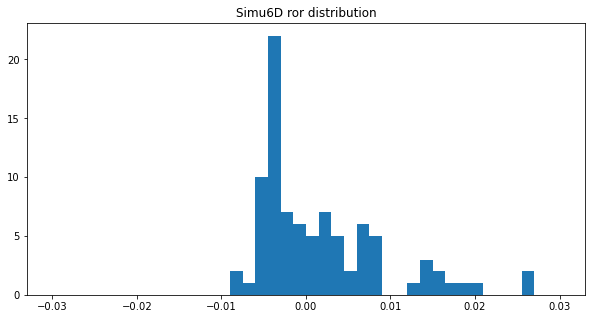

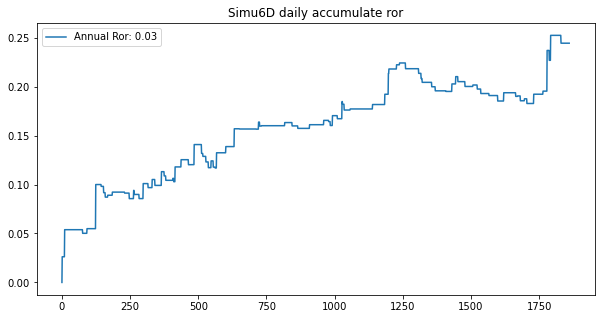

Simulate EURGBP=X


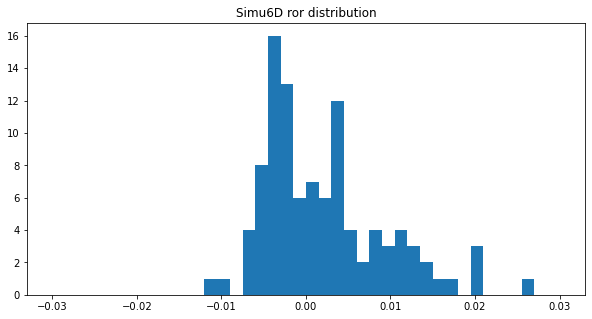

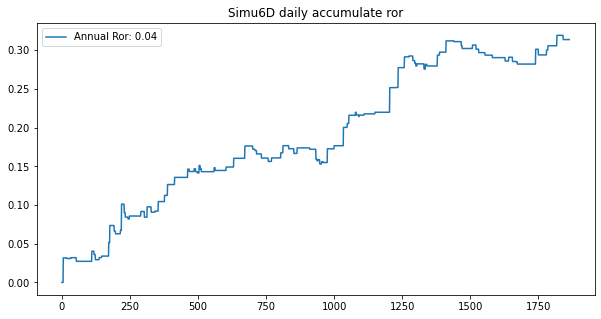

Simulate EURJPY=X


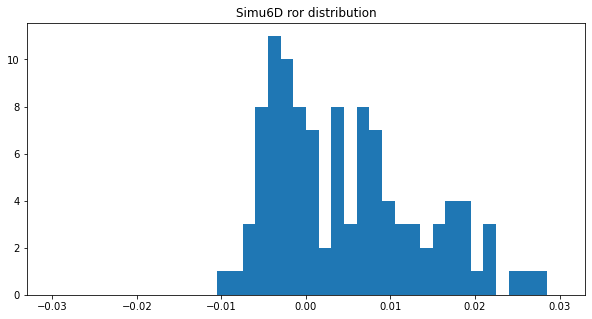

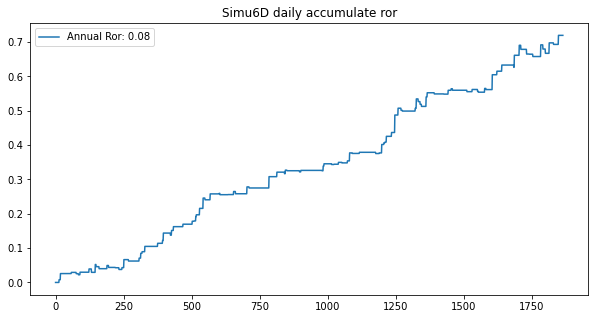

Simulate AUDUSD=X


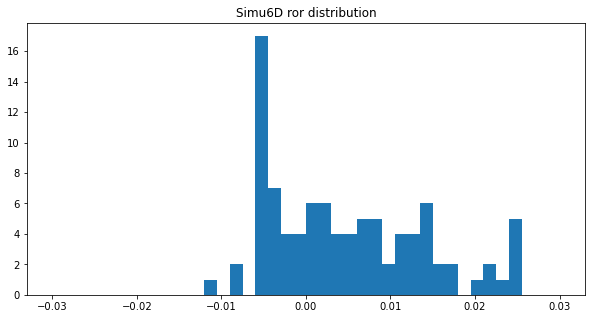

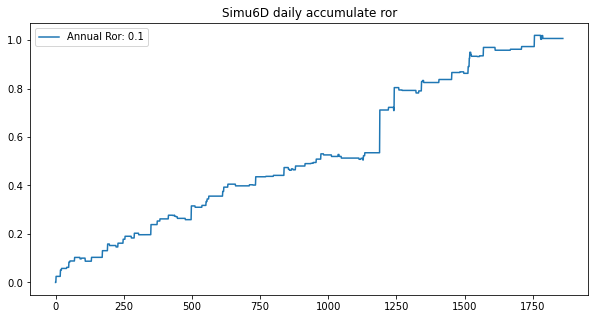

Simulate EURUSD=X


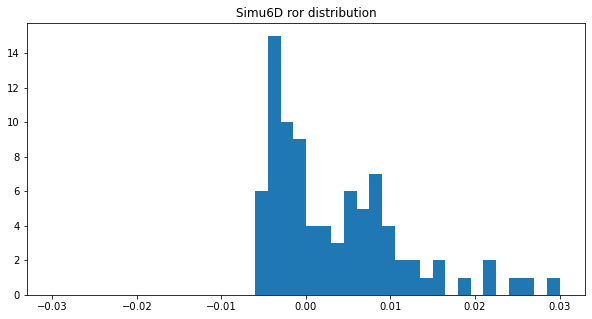

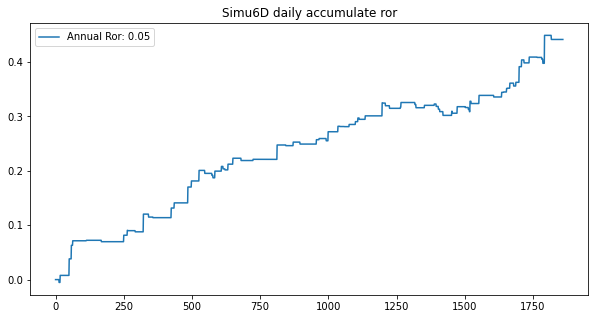

Simulate CAD=X


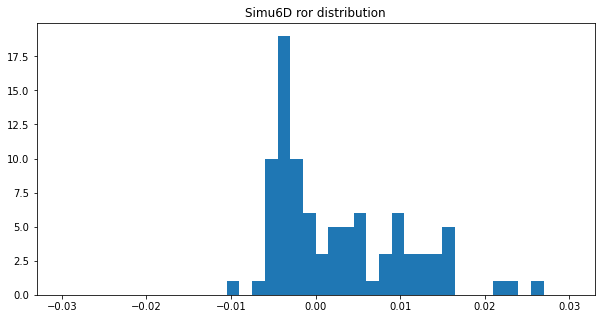

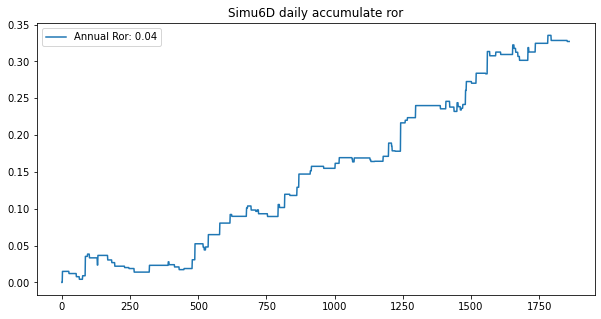

Simulate JPY=X


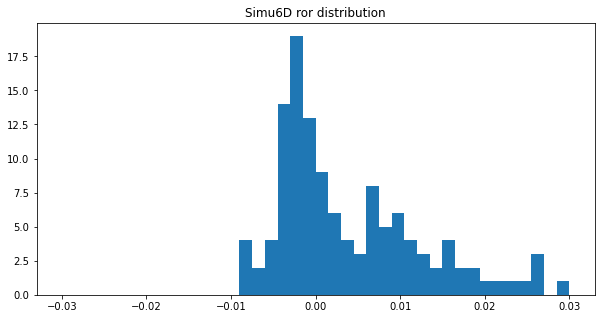

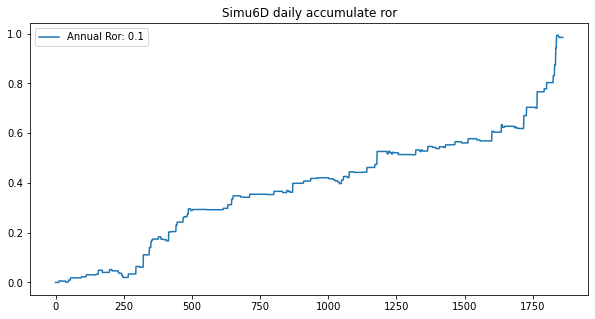

Simulate NZDUSD=X


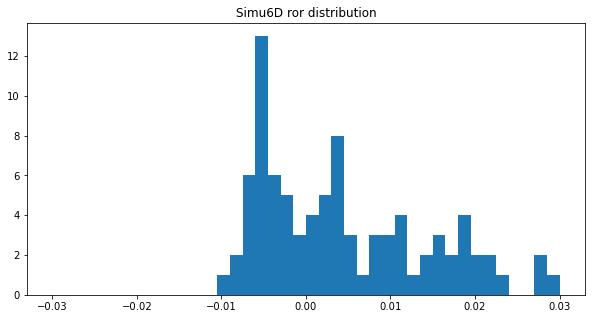

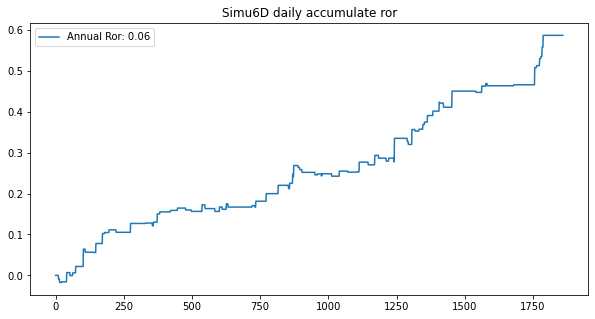

Simulate SGD=X


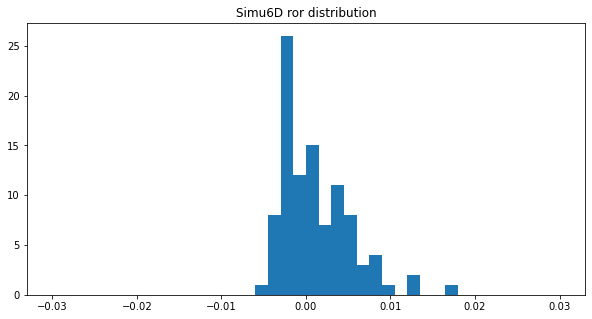

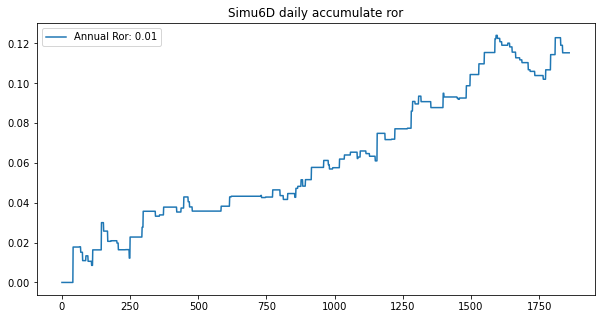

Simulate HKD=X


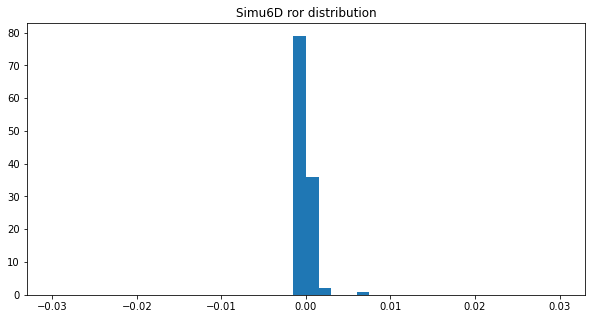

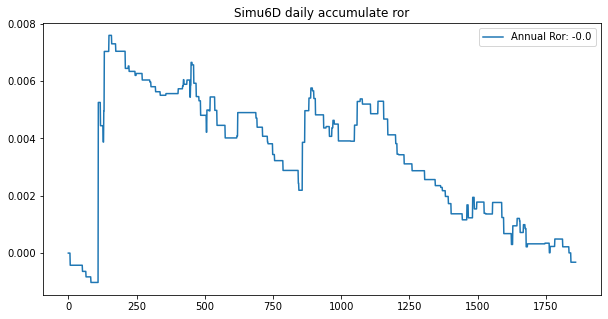

Simulate GBPUSD=X


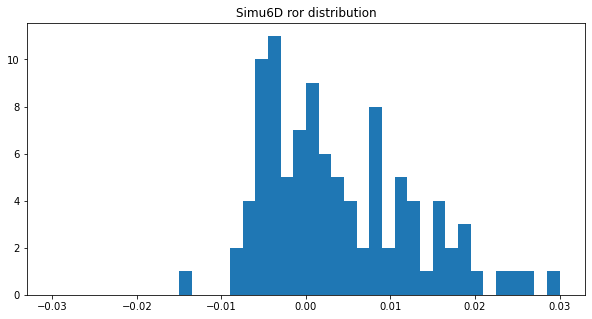

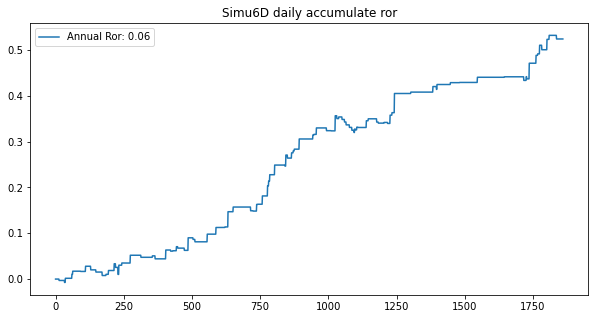

In [9]:
tickers = list(set(fx_nr_df['ticker'].tolist()))
print(tickers)
ror_3d_df = pd.DataFrame()
ror_6d_df = pd.DataFrame()
for ticker in tickers:
    print(f'Simulate {ticker}')
    fx_sp_df = fx_nr_df.where(fx_nr_df['ticker']==ticker).dropna(axis=0)
    fx_sp_df.set_index('Date',inplace=True)
    fx_sp_df.index = pd.to_datetime(fx_sp_df.index)+dt.timedelta(days=1)
    ror = simu(fx_sp_df)
    ror_3d_df = pd.concat([ror_3d_df,ror.loc[:,['ror_3d']]],axis=1)
    ror_6d_df = pd.concat([ror_6d_df,ror.loc[:,['ror_6d']]],axis=1)
ror_3d_df.columns = tickers
ror_3d_df.fillna(0,inplace=True)
ror_6d_df.columns = tickers
ror_6d_df.fillna(0,inplace=True)

In [10]:
try:
    DXY_close_df = pd.read_csv(r'E:\study\22fall\hf\data\NR4\DXY_close.csv',index_col=0)
except:
    data = yf.download(tickers='DX-Y.NYB',start = '2014-08-09',end = '2022-10-30')
    DXY_close_df = data.iloc[:,-2]
    DXY_close_df.to_csv(r'E:\study\22fall\hf\data\NR4\DXY_close.csv')

DXY_ror_df = DXY_close_df/DXY_close_df.shift(1)-1
DXY_ror_df.index = pd.to_datetime(DXY_ror_df.index)
DXY_ror_df.columns = ['DXY']
DXY_ror_df.dropna(axis=0,inplace=True)

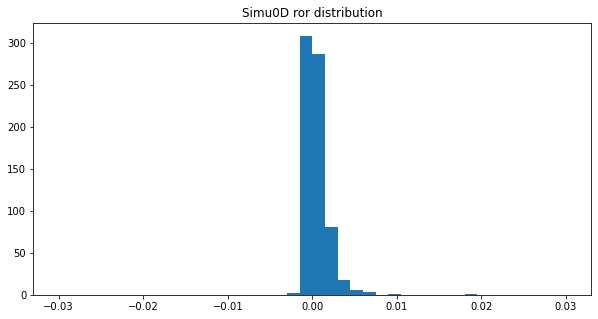

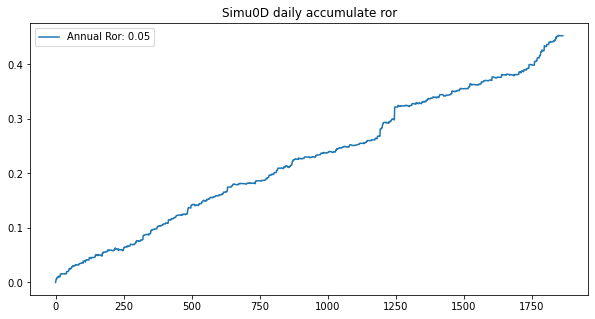

In [11]:
init_exposure_float = 1100000
ror_6d_df.to_csv('ror_fx.csv')
pfl_6d_df = ror_6d_df.mean(axis=1).to_frame().dropna(axis=0)
pfl_ror_6d_df = pfl_6d_df.copy()
pfl_ror_6d_df.columns=['ror_0d']
simu_plot(pfl_ror_6d_df,0)

In [12]:
pfl_6d_ret_df = init_exposure_float*pfl_6d_df
pfl_6d_accu_ret_df = pfl_6d_ret_df.cumsum(axis=0)
pfl_6d_df.to_csv('G10_pfl_d_ror.csv')
pfl_6d_ret_df.to_csv('G10_pfl_d_ret.csv')

In [13]:
pfl_6d_DXY_df = pd.merge(DXY_ror_df,pfl_6d_df,left_index=True,right_index=True)
pfl_6d_DXY_df.dropna(axis=0,inplace=True)
IR_6d_float = IR(pfl_6d_DXY_df.iloc[:,1].values,pfl_6d_DXY_df.iloc[:,0].values)
Sharp_6d_float = sharp(pfl_6d_DXY_df.iloc[:,1].values)
d6_beta_float = cal_beta(pfl_6d_DXY_df.iloc[:,1].values,pfl_6d_DXY_df.iloc[:,0].values)
d6_maxdrawdown_float = max_drawdown(pfl_6d_accu_ret_df)
d6_VaR_float = VaR(0.99,pfl_6d_ret_df)
d6_ETL_float = ETL(0.99,pfl_6d_ret_df)
d6_annualized_ror_float = annualized_ror(pfl_6d_DXY_df.iloc[:,1].values)
'''pfl_3d_df = ror_3d_df.mean(axis=1).to_frame().dropna(axis=0)
pfl_3d_ret_df = init_exposure_float*pfl_3d_df
pfl_3d_accu_ret_df = pfl_3d_ret_df.cumsum(axis=0)
pfl_3d_DXY_df = pd.merge(DXY_ror_df,pfl_3d_df,left_index=True,right_index=True)
pfl_3d_DXY_df.dropna(axis=0,inplace=True)
IR_3d_float = IR(pfl_3d_DXY_df.iloc[:,1].values,pfl_3d_DXY_df.iloc[:,0].values)
Sharp_3d_float = sharp(pfl_3d_DXY_df.iloc[:,1].values)
d3_beta_float = cal_beta(pfl_3d_DXY_df.iloc[:,1].values,pfl_3d_DXY_df.iloc[:,0].values)
d3_maxdrawdown_float = max_drawdown(pfl_3d_accu_ret_df)
d3_VaR_float = VaR(0.99,pfl_3d_ret_df)
d3_ETL_float = ETL(0.99,pfl_3d_ret_df)
d3_annualized_ror_float = annualized_ror(pfl_3d_DXY_df.iloc[:,1].values)'''

'''stat_df = pd.DataFrame(data = [[IR_3d_float,Sharp_3d_float,d3_beta_float,d3_maxdrawdown_float,d3_VaR_float,d3_ETL_float,d3_annualized_ror_float*100],[IR_6d_float,Sharp_6d_float,d6_beta_float,d6_maxdrawdown_float,d6_VaR_float,d6_ETL_float,d6_annualized_ror_float*100]])'''
stat_df = pd.DataFrame(data = [[IR_6d_float,Sharp_6d_float,d6_beta_float,d6_maxdrawdown_float,d6_VaR_float,d6_ETL_float,d6_annualized_ror_float*100]])
stat_df = stat_df.T
stat_df.index = ['Annualized IR','Annualized Sharp','Beta','max drawdown','VaR','ETL','AnnualizedRor%']
stat_df.columns = ['6D']
print(stat_df)

                           6D
Annualized IR        0.414586
Annualized Sharp     1.384838
Beta                -0.008400
max drawdown      1125.558482
VaR               -948.224536
ETL              -1286.721463
AnnualizedRor%       5.269851
